### Load the package.

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import sys; sys.path.append("..") # clean up with a correct install....

from access import *

import pandas as pd
import geopandas as gpd

### Load the examples data.

The single example file contains demand (population) and multiple supplies (primary care physicians and dentists) on a single location index (the 2010 Census Tract's FIPS code / geoid).

For now, everything is aligned by Census tract, so we'll just pull apart the pieces.  Normally, these might come from different data sources where populations and services are in different locations.  

In [38]:
il_med = gpd.read_file("../examples/il_med/il_med.geojson").set_index("geoid")

In [39]:
il_med.head()

,doc,dentist,pop,geometry
geoid,,,,
17001000100,0,2,4627,POINT (41190.96521215544 368296.2161574106)
17001000201,0,0,1986,POINT (39069.51353751949 369584.0955003587)
17001000202,0,0,2999,POINT (39114.95024493745 367995.9409450263)
17001000400,3,0,4322,POINT (37273.52522412403 368795.8152967723)
17001000500,10,0,2337,POINT (38120.33621561436 368060.4575544588)


In [40]:
#Uncomment to download example network time data.
! wget https://saxon.harris.uchicago.edu/~jsaxon/il_fca_data/il_times.csv -O ../examples/il_med/il_times.csv

/bin/sh: wget: command not found


### Load this network distance.

The il_times.csv contains geoid fields for the origin and destination tracts and a cost field (number of minutes it takes to travel from origin to destination). See the main site's cost matrix section for hints on downloading lots of travel times like this. 

In [41]:
times = pd.read_csv("../examples/il_med/il_times.csv").rename(columns = {"destination" : "dest"})

In [42]:
times.head()

,origin,dest,cost
0,17001000100,17001000201,11.614100
1,17001000100,17001000202,9.640357
2,17001000100,17001000400,13.565972
3,17001000100,17001000500,11.998176
4,17001000100,17001000600,8.591976


### Create the access object.

Since we have geometries here, it could be as simple as this:

In [43]:
A = access(demand_df = il_med[["pop", "geometry"]], demand_value = 'pop', 
           supply_df = il_med[["doc", "dentist", "geometry"]], supply_value = ["doc", "dentist"])

In this case, we would _have_ to generate the distance matrix on the fly.

Instead, I'll create a slightly more complicated version with all of the possible matrices:

In [44]:
A = access(demand_df = il_med[["pop", "geometry"]], demand_value = 'pop', 
           supply_df = il_med[["doc", "dentist", "geometry"]], supply_value = ["doc", "dentist"], 
           demand_index = True, supply_index = True,
           cost_df   = times,  cost_name = 'cost',
           cost_origin = 'origin', cost_dest = 'dest',
           neighbor_cost_df = times, neighbor_cost_name = 'cost',
           neighbor_cost_origin = 'dest', neighbor_cost_dest = 'origin')

### Add an additional distance measure. 

Now, we can still add a Euclidean distance matrix (this requires projected data).  Note that this is a very costly operation, but you only have to do it once.  `threshold` is the maximum distance that we will consider.  Calculating distances between centroids takes a while but is still faster than computing distances to polygons (crazy expensive, though we've been moderately careful to make it faster).

In [45]:
A.euclidean_distance(threshold = 250000, centroid_o = True, centroid_d = True)

### Create some weights functions

Of course, you don't _have_ to do this, but it's fun to play with different versions of spatial access, esp. E2SFCA.

In [46]:
# create the weighting function
# from stepwise weight dictionaries
fn30 = weights.step_fn({10 : 1, 20 : 0.68, 30 : 0.22})
fn60 = weights.step_fn({20 : 1, 40 : 0.68, 60 : 0.22})

# or gaussian weights.
# This could also be done through scipy.stats.norm().pdf, 
#   but that turns out to be unacceptably slow.
gaussian = weights.gaussian(60)

# A conventional gravity model is just weighted catchment with gravity weighting.
gravity = weights.gravity(scale = 60, alpha = -1)

### Ready to roll...

* Now just call the access functions.  
* Each of these will return the corresponding series, but they are also stored in `A.access_df`.  Check out the documentation for the possible arguments.  
* Note that if you call the same function repeatedly, with different arguments, you may want to change the name, to avoid overwriting.
* By default, `access` will be calculated for sequential, for all of the supply columns.

In [47]:
A.weighted_catchment    (name = "gravity",  weight_fn = gravity)
A.fca_ratio             (name = "fca",      max_cost = 15)
A.fca_ratio             (name = "fca",      max_cost = 30) # Note - the warning -- good!
A.fca_ratio             (name = "fca60",    max_cost = 60)
A.fca_ratio             (name = "fca90",    max_cost = 90)
A.two_stage_fca         (name = "2sfca",    max_cost = 60)
A.enhanced_two_stage_fca(name = "2sfca30",  weight_fn = fn30)
A.enhanced_two_stage_fca(name = "2sfca60",  weight_fn = fn60)
A.enhanced_two_stage_fca(name = "g2sfca",   weight_fn = gaussian)
A.three_stage_fca       (name = "3sfca")

A.raam(name = "raam", tau = 60);
A.raam(name = "raam30", tau = 30);

access INFO     :: Using default cost, cost, for gravity.
access INFO     :: Using default cost, cost, for fca.
access INFO     :: Using default cost, cost, for fca.
access INFO     :: Using default cost, cost, for fca.
access INFO     :: Using default cost, cost, for fca.
access INFO     :: Overwriting fca_doc.
access INFO     :: Overwriting fca_dentist.
access INFO     :: Using default cost, cost, for fca60.
access INFO     :: Using default cost, cost, for fca60.
access INFO     :: Using default cost, cost, for fca90.
access INFO     :: Using default cost, cost, for fca90.
access INFO     :: Using default cost, cost, for 2sfca.
access INFO     :: Using default cost, cost, for 2sfca30.
access INFO     :: Using default cost, cost, for 2sfca60.
access INFO     :: Using default cost, cost, for g2sfca.
access INFO     :: Using default cost, cost, for 3sfca.
access INFO     :: Using default cost, cost, for raam.
access INFO     :: Using default cost, cost, for raam30.


These were all with network travel time, in minutes.  We could also run the calculation with Euclidean distance.  Note that the parameters for the access fucntion will be dramatically different in meters instead of minutes!  Here, RAAM's tau parameter shifts from 60 minutes to 100 km (1e5 meters).

In [48]:
A.raam(name = "raam_euclidean", tau = 1e5, cost = "euclidean");

Gosh -- that's lots of access measures!  Let's simplify our life, with just one:

In [49]:
A.score(name = "raam_combo", col_dict = {"raam_doc" : 0.8, "raam_dentist" : 0.2});

If there were only one cost function available, these logs wouldn't print.

If you found all the logs annoying instead of useful, then turn them off:

In [50]:
A.log.setLevel(logging.WARNING)

### Results time!

Let's get the correlations among measures, and plot a few of them...

In [51]:
A.norm_access_df.columns

Index(['2sfca30_dentist', '2sfca30_doc', '2sfca60_dentist', '2sfca60_doc',
       '2sfca_dentist', '2sfca_doc', '3sfca_dentist', '3sfca_doc',
       'fca60_dentist', 'fca60_doc', 'fca90_dentist', 'fca90_doc',
       'fca_dentist', 'fca_doc', 'g2sfca_dentist', 'g2sfca_doc',
       'gravity_dentist', 'gravity_doc', 'raam30_dentist', 'raam30_doc',
       'raam_combo', 'raam_dentist', 'raam_doc', 'raam_euclidean_dentist',
       'raam_euclidean_doc'],
      dtype='object')

In [52]:
A.norm_access_df.corr().raam_doc.abs().sort_values(ascending = False)

raam_doc                  1.000000
raam_combo                0.988777
raam30_doc                0.971267
raam_euclidean_doc        0.918173
raam30_dentist            0.839326
gravity_doc               0.803273
gravity_dentist           0.801074
raam_dentist              0.790399
2sfca60_dentist           0.782756
2sfca60_doc               0.779705
3sfca_doc                 0.777999
g2sfca_dentist            0.752172
2sfca30_doc               0.747478
g2sfca_doc                0.730953
2sfca30_dentist           0.726784
raam_euclidean_dentist    0.721868
2sfca_dentist             0.683203
3sfca_dentist             0.655556
2sfca_doc                 0.627037
fca_dentist               0.168248
fca_doc                   0.143010
fca90_doc                 0.101256
fca90_dentist             0.052718
fca60_dentist             0.036530
fca60_doc                 0.028182
Name: raam_doc, dtype: float64

In [53]:
il_map = il_med[["geometry"]].join(A.norm_access_df, how = "inner")

def plot(v, swap = False, ax = None, leg = True):
    
    il_map.plot(v, legend = leg, figsize = (5, 5), cmap = "viridis" if swap else "viridis_r", 
                markersize = 1.5, alpha = 0.5, ax = ax,
                vmin = il_map[v].quantile(0.05), vmax = il_map[v].quantile(0.95)).set_axis_off()

Plotting RAAM for spatial access to doctors from Illinois tracts:

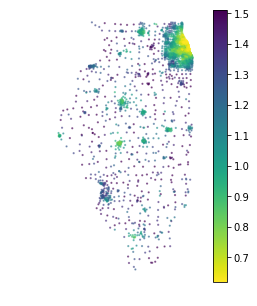

In [54]:
plot("raam_doc")

Plotting 3-Stage Floating Catchment Areas for for spatial access to dentists from Illinois tracts:

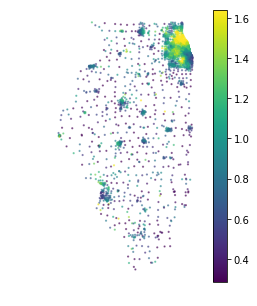

In [55]:
plot("3sfca_dentist", swap = True)

Fascinating!  Is it true that the dentist shortage on Chicago's South Side is more acute than for doctors?  This would not be a total shock, since Medicare boosts demand for healthcare but not dental care in poor areas -- and since the University of Chicago Hospital is bigish.  Let's do the apples to apples comparison, with RAAM.

From left to right, maps of RAAM for doctors, dentists and both:

In [56]:
fig, ax = plt.subplots(1, 3, subplot_kw = {"aspect" : "equal"})
for axi in ax: axi.set_axis_off()

plot("raam_doc",     ax = ax[0], leg = False)
plot("raam_dentist", ax = ax[1], leg = False)
plot("raam_combo",   ax = ax[2], leg = False)

NameError: name 'plt' is not defined

Seems to be the case...

Now you can save all model results to a csv file (same directory as input data):

In [57]:
A.norm_access_df.to_csv('../examples/il_med/results.csv')

Gravity works too (here for doctors).  Not really appropriate in this case, since there is fixed supply.

In [ ]:
v = "gravity_doc"
il_map.plot(v, legend = True, figsize = (5, 5), cmap = "viridis", markersize = 1.5, alpha = 0.5,
            vmin = il_map[v].quantile(0.05), vmax = il_map[v].quantile(0.95)).set_axis_off()